# Gradient and Automatic Differentiation

## Gradient

In mathematics, the gradient is a vector that points in the direction of the steepest increase of a function at a particular point. It is often denoted by the symbol ∇ (nabla). The gradient provides information about the rate and direction of change of a function.

For a function f(x₁, x₂, ..., xn) of n variables, the gradient is defined as:

∇f = (∂f/∂x₁, ∂f/∂x₂, ..., ∂f/∂xn)

Each component of the gradient vector represents the partial derivative of the function with respect to the corresponding variable.

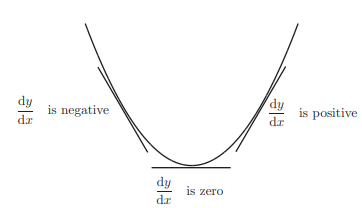

## Automatic Differentiation
- [wiki link](https://en.wikipedia.org/wiki/Automatic_differentiation)
- [How automatic differentiation works](https://www.youtube.com/watch?v=jS-0aAamC64)
- [How automatic differentiation words](https://www.youtube.com/watch?v=R_m4kanPy6Q)
- In TensorFlow, automatic differentiation is a fundamental component of its computational graph framework. TensorFlow provides a mechanism called "**tf.GradientTape**" that enables automatic differentiation for computing gradients.

- Automatic differentiation is useful for implementing machine learning algorithms such as **backpropagation** for training neural networks.

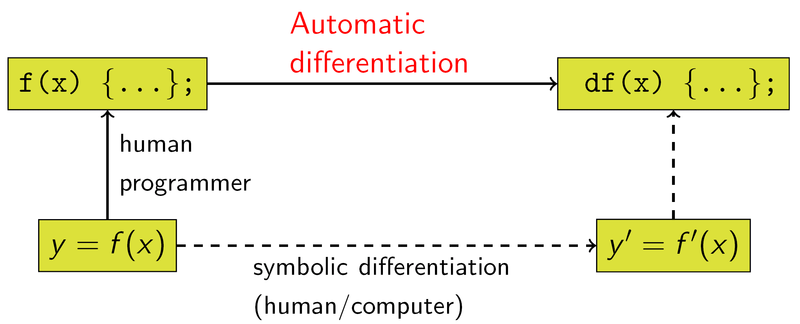

## Types of Automatic Differentiation
- **Forward Automatic Differentiation**

Forward-mode AD computes the derivative of a function with respect to a single input variable while evaluating the function. It proceeds by applying the chain rule from the input variable towards the output, propagating both the function value and the derivative. The main advantage of forward-mode AD is that it efficiently computes the derivatives of a function for multiple input variables simultaneously. However, it can be less efficient than reverse-mode AD when the number of input variables is large compared to the number of outputs.

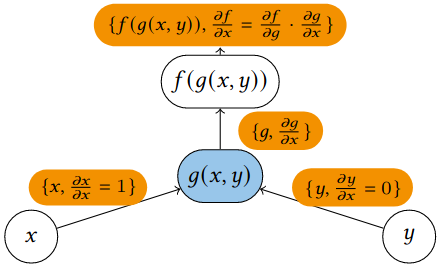
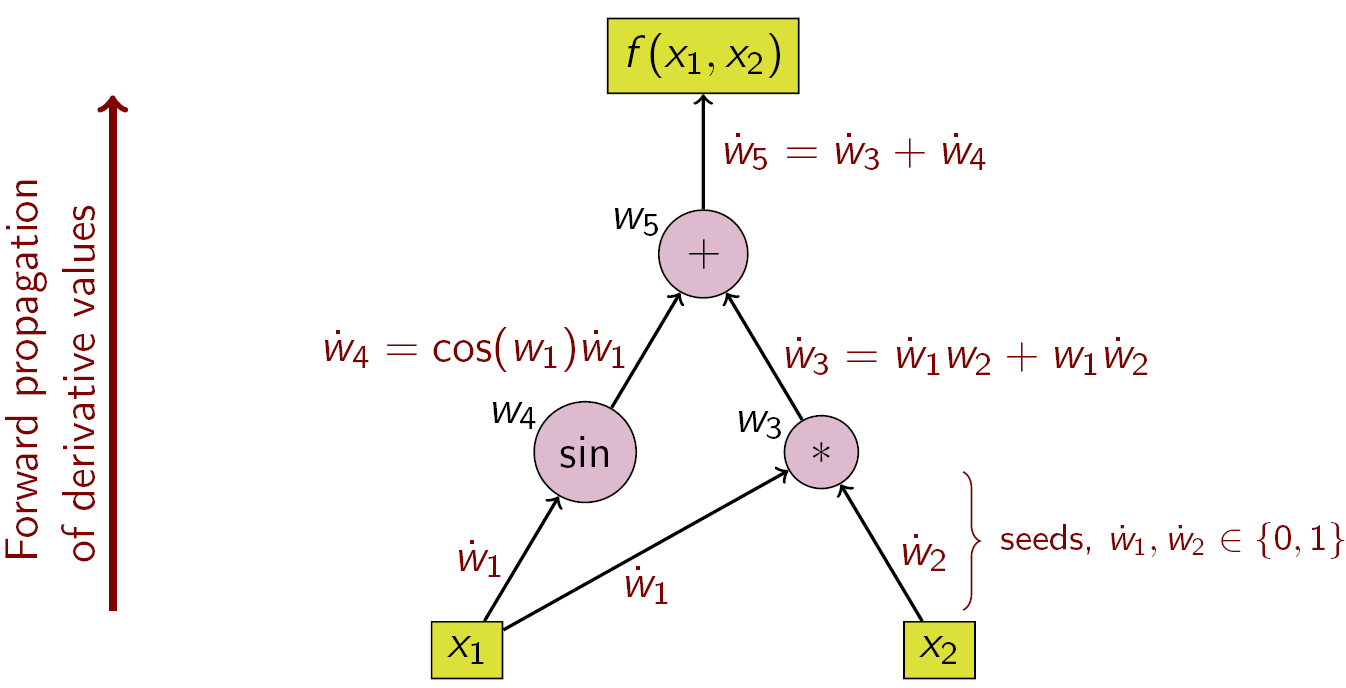

- **Reversed Automatic Differentiation**

Reverse-mode AD, also known as backpropagation, computes the derivative of a function with respect to all input variables simultaneously. It performs a two-pass computation: first, it evaluates the function while keeping track of intermediate values, and then it computes the derivatives by backward propagation using the chain rule. Reverse-mode AD is particularly efficient when the number of input variables is large compared to the number of outputs, which is often the case in machine learning models with many parameters. It is widely used in training deep neural networks because it efficiently computes the gradients with respect to the model's parameters.
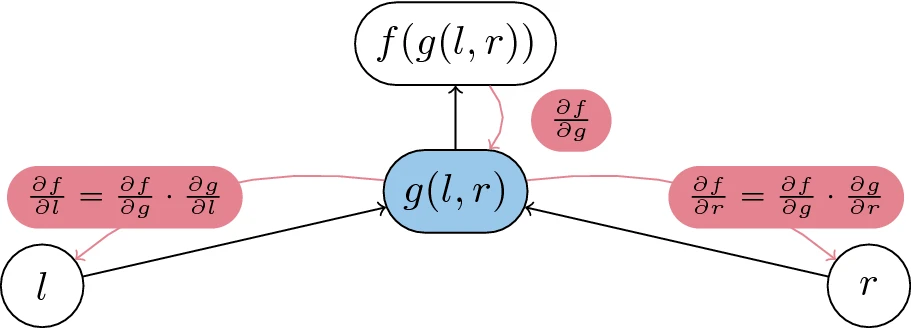
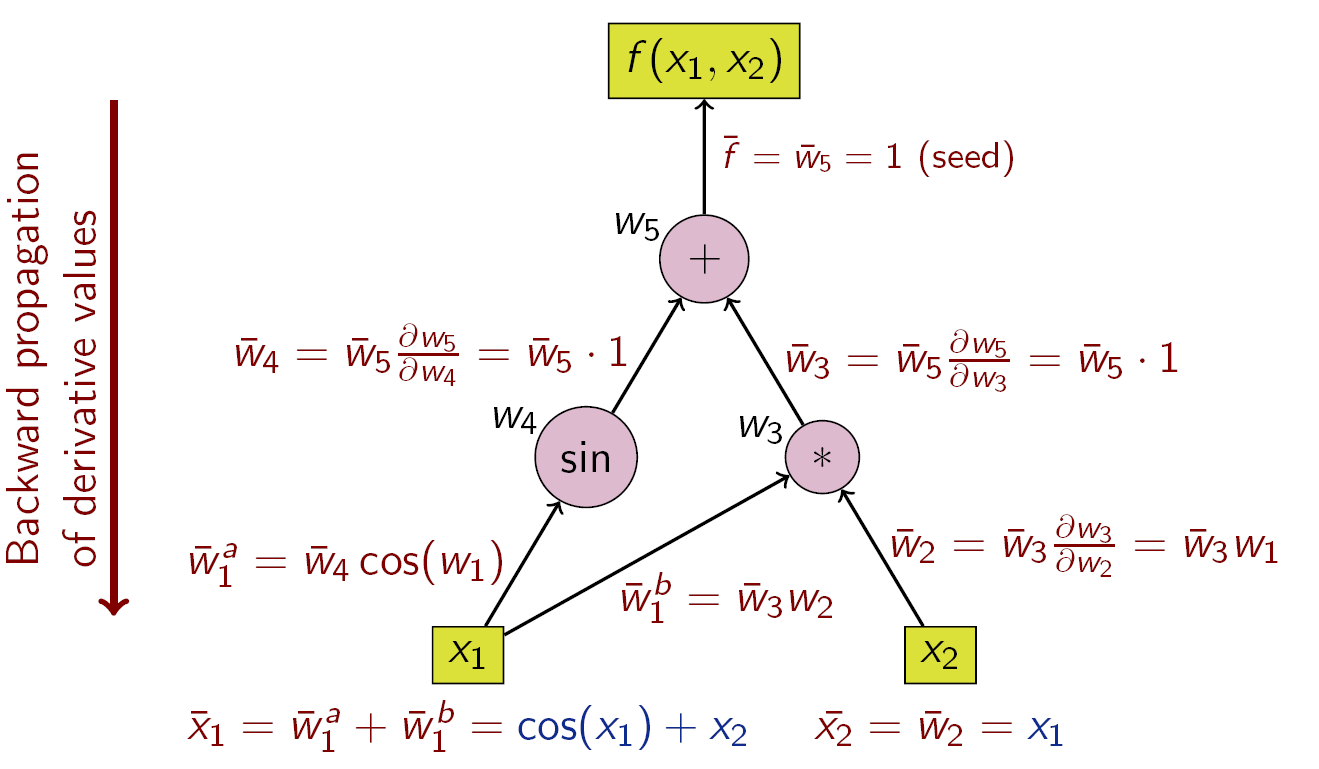


### Reversed Auto Differentiation

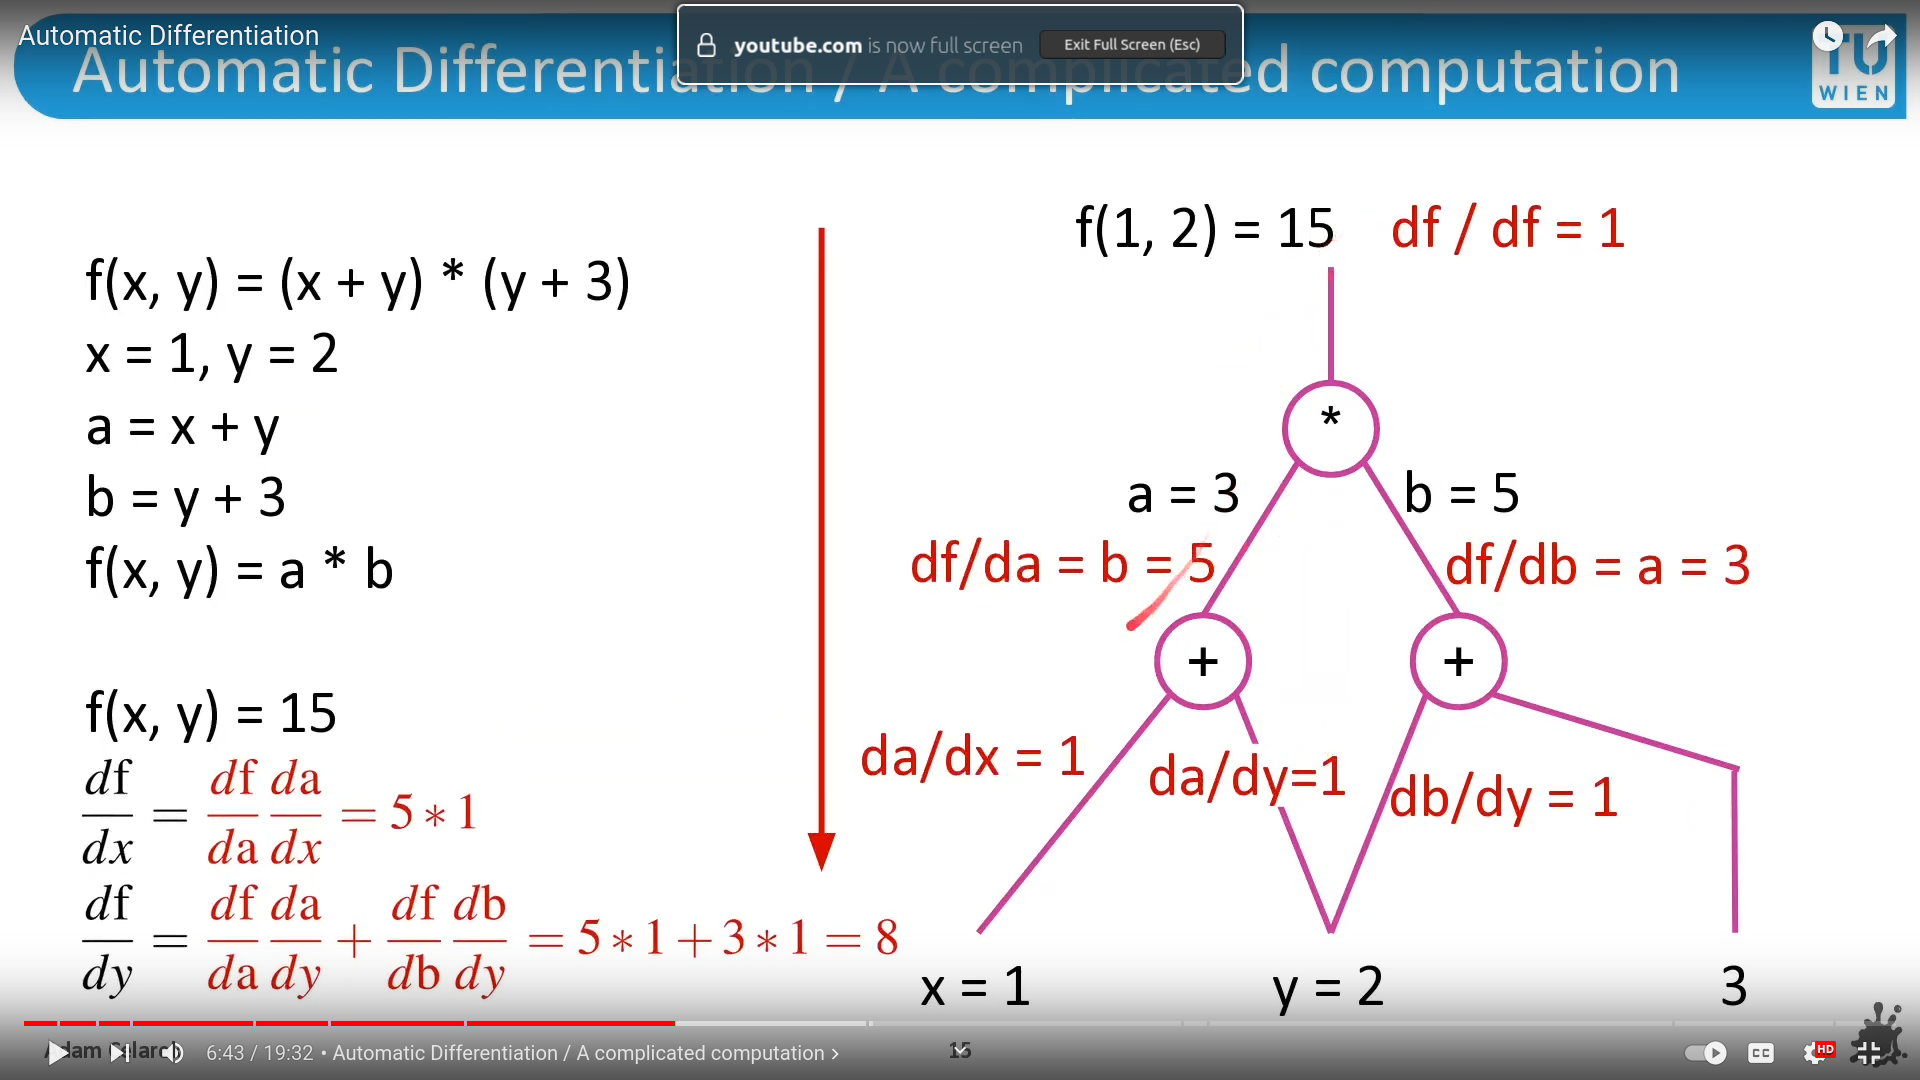

### Limitation of Forward-mode AD
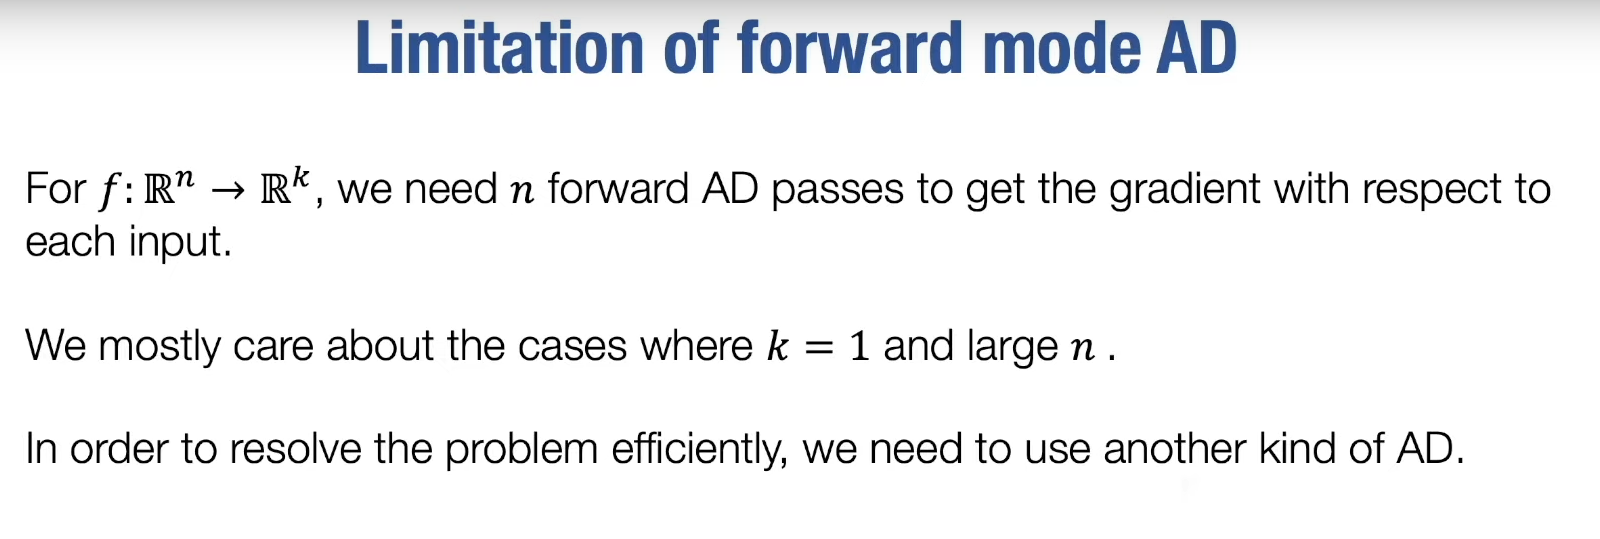

where n is the number of inputs and k is the number of outputs

# Gradient Tape

- In TensorFlow, **tf.GradientTape** is a powerful API that allows you to compute gradients of operations with respect to variables.
- usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using **reverse mode differentiation**.


In [212]:
import tensorflow as tf

Note the tape will automatically watch a **tf.Variable** but not a **tf.Tensor**.

In [213]:
x = tf.Variable(3.0, trainable=True) #trainable is true by default

with tf.GradientTape() as tape:
#     tape.watch(x)
    y = x**2

In [214]:
# y = x**2
# y' = 2*x
# y' = 2*3 = 6
dy_dx = tape.gradient(y, x)

In [215]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

### Gradient of a loss function

In [232]:
w = tf.Variable(tf.random.normal((3, 2)), name="weight")
b = tf.Variable(tf.zeros(2), name="bias")
x = tf.Variable([[1., 1. , 0.]], name="input")

x.shape, w.shape, b.shape

(TensorShape([1, 3]), TensorShape([3, 2]), TensorShape([2]))

In [233]:
with tf.GradientTape() as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

In [234]:
# we can also pass multiple sources as a dictionary, the output will be a dict object
params = {
    'w': w,
    'b': b
}
grads  = tape.gradient(loss, params)

In [235]:
grads

{'w': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[2.1281905 , 0.57798004],
        [2.1281905 , 0.57798004],
        [0.        , 0.        ]], dtype=float32)>,
 'b': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.1281905 , 0.57798004], dtype=float32)>}

In [236]:

with tf.GradientTape() as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

# alternatively, we can also pass as a list of sources
dloss_dw, dloss_db = tape.gradient(loss, [w, b])

In [237]:
dloss_dw, dloss_db

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[2.1281905 , 0.57798004],
        [2.1281905 , 0.57798004],
        [0.        , 0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.1281905 , 0.57798004], dtype=float32)>)

In [238]:
# show watched variables
[var.name for var in tape.watched_variables()]

['weight:0', 'bias:0', 'input:0']

In [239]:
tape.watched_variables()

(<tf.Variable 'weight:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.67231524,  0.6763184 ],
        [ 1.4558754 , -0.09833835],
        [ 0.6568356 , -1.2204736 ]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'input:0' shape=(1, 3) dtype=float32, numpy=array([[1., 1., 0.]], dtype=float32)>)

## Gradient of Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside the tf.GradientTape context.

In [240]:
with tf.GradientTape() as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)
    
# intermediate result --> y
dloss_dy = tape.gradient(loss, y)
dloss_dy

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.1281905 , 0.57798004]], dtype=float32)>

By default, the resources held by a GradientTape are released as soon as the GradientTape.gradient method is called. To compute multiple gradients over the same computation, create a gradient tape with persistent=True.

In [241]:
try:
    dloss_dy = tape.gradient(loss, y)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


- **Note** When ***persistent=True*** is set, it allows you to call ***tape.gradient()*** multiple times to compute gradients for different target variables without needing to retrace the operations. It can be useful when you want to compute gradients for multiple targets while reusing the recorded operations.

In [242]:
with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)
    
# intermediate result --y
dloss_dy = tape.gradient(loss, y)
dloss_dy

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.1281905 , 0.57798004]], dtype=float32)>

In [243]:
# This time it doesnot throw an non-persistent GradientTape exception
dloss_dy = tape.gradient(loss, y)
dloss_dy

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.1281905 , 0.57798004]], dtype=float32)>

## Gradient of multiple targets

In [246]:
with tf.GradientTape(persistent=True) as tape:
    y0 = x
    y1 = x**2

In [249]:
dy1 = tape.gradient(y1, x)
dy0 = tape.gradient(y0, x)

dy1, dy0, x

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2., 2., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1., 1., 1.]], dtype=float32)>,
 <tf.Variable 'input:0' shape=(1, 3) dtype=float32, numpy=array([[1., 1., 0.]], dtype=float32)>)

In [250]:
tape.gradient({"y0": y0, 'y1': y1}, x)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3., 3., 1.]], dtype=float32)>

You have noticed that when we have multiple targets then the result will be summed, this is basically the gradient of the sum of the targets.

In [141]:
x1 = tf.Variable(2.)

with tf.GradientTape() as tape:
    y1 = x1 * [3., 4.]


print(tape.gradient(y1, x1).numpy())

7.0


Similarly, if the target(s) are not scalar the gradient of the sum is calculated.

This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

### Control flow

- Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, if and while statements).
- Just remember that the control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

In [207]:
x = tf.Variable(-1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)


with tf.GradientTape(persistent=True) as tape:
#     tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

None
tf.Tensor(4.0, shape=(), dtype=float32)


- The gradient only connects to the variable that was used
- Depending on the value of x in the above example, the tape either records result = v0 or result = v1**2 

In [184]:
x = tf.Variable(1.0)
dx = tape.gradient(result, x)

print(dx)

None


The gradient with respect to x is always None, if X is used as a condition for conditional statements.

**what will happen when we assign a new value to the variable and execute the tape.gradient()?**

In [229]:
# Create some variables
x = tf.Variable(2.0)
y = tf.Variable(3.0)

# Open a gradient tape context with persistent=True
with tf.GradientTape(persistent=True) as tape:
    # Perform some computations based on condition
    if x > y:
        z = x ** 2
    else:
        z = y ** 3

# Compute the gradient of z with respect to x and y
gradients = tape.gradient(z, [x, y])

# Print the gradients
print(gradients)

# Change the values of x and y
x.assign(4.0)
y.assign(5.0)

# Compute gradients again without retracing
gradients_updated = tape.gradient(z, [x, y])

# Print the updated gradients
print(gradients_updated)

# Release the tape resources
del tape


[None, <tf.Tensor: shape=(), dtype=float32, numpy=27.0>]
[None, <tf.Tensor: shape=(), dtype=float32, numpy=27.0>]


**Explaination:** 
- The persistence feature allows you to compute multiple gradients within the same tape context, but it doesn't retain information about changes to variables made after the initial gradient computation.
- TensorFlow's gradient tape records operations in a forward pass and uses those recorded operations to compute gradients during the backward pass. Once you have executed **tape.gradient()**, the tape is "consumed," and it no longer retains information about subsequent changes to variables.

## Cases when gradient returns None [*more*](https://www.tensorflow.org/guide/autodiff#cases_where_gradient_returns_none)
- When target is not connected to the souce
- Replace a variable with tensor
- did calculation outside of tensorflow
    - when you use numpy operations inside the gradient tape
- took gradient through an integer or string
    - Integer and string are note differentiable
- Took gradient through a stateful object
    - State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.